In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
import graphviz

In [2]:
df = pd.read_csv('data/ames_housing_trimmed_processed.csv')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [3]:
df.shape

(1460, 57)

In [4]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Trees as base learners

In [6]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10)
xg_reg.fit(X_train, y_train)

[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [7]:
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, y_pred))
rmse

41893.41701280149

### Linear base learners

In [8]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

params = {'booster': 'gblinear', 'objective':'reg:linear'}

In [9]:
xg_linreg = xgb.train(params=params, dtrain=DM_train, num_boost_round=5)

[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
y_pred_lin = xg_linreg.predict(DM_test)
rmse = np.sqrt(MSE(y_test, y_pred_lin))
rmse

50517.2548440185

### Evaluating model quality

In [11]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":4}

In [12]:
# computing root mean squared error
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, 
                    metrics='rmse', as_pandas=True, seed=123)

cv_results

[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141767.533478,429.451090,142980.434934,1193.795492
1,102832.547530,322.472076,104891.395389,1223.157368
2,75872.617039,266.474211,79478.938743,1601.345019
3,57245.651780,273.624239,62411.921348,2220.150063
4,44401.298519,316.423620,51348.279619,2963.378136


In [13]:
cv_results["test-rmse-mean"].tail(1).values[0]

51348.27961876997

In [14]:
# computing root mean absolute error
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, 
                    metrics='mae', as_pandas=True, seed=123)

cv_results

[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,127343.480012,668.306786,127633.999275,2404.005913
1,89770.056424,456.963854,90122.501070,2107.909841
2,63580.789280,263.405054,64278.558741,1887.567534
3,45633.156501,151.883868,46819.168555,1459.818435
4,33587.090044,86.998100,35670.647207,1140.607311


In [15]:
cv_results["test-mae-mean"].tail(1).values[0]

35670.64720676369

### Using regularization

In [16]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
reg_params = [1, 10, 100]
params = {"objective":"reg:linear","max_depth":3}

In [17]:
rmses_l2 = []
for reg in reg_params:
    params["lambda"] = reg
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, 
                             metrics="rmse", as_pandas=True, seed=123)
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [18]:
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  52275.357003
1   10  57746.063828
2  100  76624.627811


### Visualizing individual XGBoost trees

In [19]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":2}

xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

[12:35:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


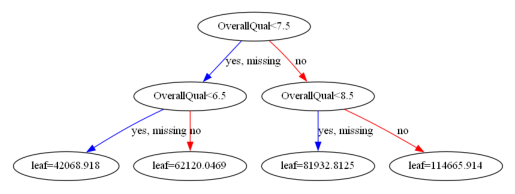

In [20]:
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

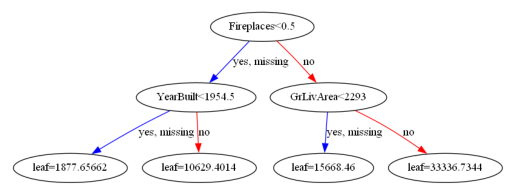

In [21]:
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

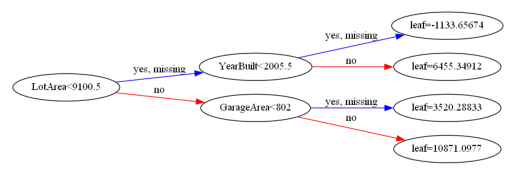

In [22]:
xgb.plot_tree(xg_reg, num_trees=9, rankdir='LR')
plt.show()

### Visualizing feature importances

In [23]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":4}

xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

[12:35:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


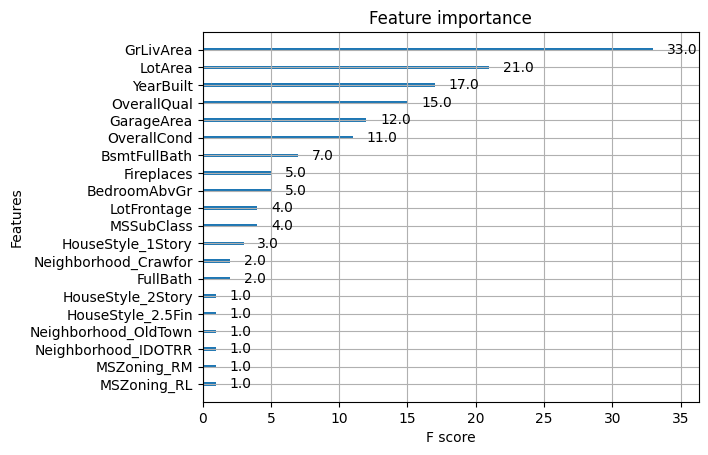

In [24]:
xgb.plot_importance(xg_reg)
plt.show()

### Tuning number of boosting rounds

In [25]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":3}
num_rounds = [5, 10, 15]

In [26]:
final_rmse_per_round = []
for curr_num_rounds in num_rounds:
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, 
                        num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True)
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

    
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

### Automated boosting round using early stopping (fine tuning)

In [27]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":4}

cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=50, 
                    early_stopping_rounds=10, metrics='rmse', as_pandas=True)

cv_results

[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141898.058497,974.600280,142860.781653,1942.504298
1,103118.563370,746.219841,104814.924284,1494.335701
2,76108.863281,600.353696,78575.198706,1452.761452
3,57371.047729,524.583273,61392.469003,2081.372177
4,44469.140816,529.878016,49914.604877,2067.913783
5,35790.568205,411.048456,43038.004476,2312.200524
6,29950.939403,522.578898,38669.133561,2382.996461
7,25994.930699,497.263926,36166.708116,2863.730357
8,23442.129134,505.525882,34579.571932,2790.819920
9,21637.197223,465.667756,33712.104664,3073.703579


### Tuning eta (learning rate)

In [28]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":3}

eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

for curr_val in eta_vals:
    params["eta"] = curr_val
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=10, 
                        early_stopping_rounds=5, metrics='rmse', as_pandas=True)
    
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])
    
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

[12:47:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

### Tuning max_depth

In [30]:
housing_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"reg:linear"}

max_depths = [2, 5, 10, 20]
best_rmse = []

for curr_val in max_depths:
    params["max_depth"] = curr_val
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=10, 
                        early_stopping_rounds=5, metrics='rmse', as_pandas=True)
    
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])
    
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

[12:56:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

### Tuning colsample_bytree

In [32]:
housing_dmatrix = xgb.DMatrix(data=X,label=y)
params={"objective":"reg:linear","max_depth":3}

colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_rmse = []

for curr_val in colsample_bytree_vals:
    params['colsample_bytree'] = curr_val
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=10, 
                        early_stopping_rounds=5, metrics="rmse", as_pandas=True)
    
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

[13:10:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

### Grid search with XGBoost

In [34]:
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1)

grid_mse.fit(X, y)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7], 'max_depth': [2, 5],
                         'n_estimators': [50]},
             scoring='neg_mean_squared_error', verbose=1)

In [35]:
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Best parameters found:  {'colsample_bytree': 0.3, 'max_depth': 5, 'n_estimators': 50}
Lowest RMSE found:  28986.18703093561


### Random search with XGBoost

In [38]:
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

gbm = xgb.XGBRegressor(n_estimators=10)

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                                    scoring='neg_mean_squared_error', n_iter=5, cv=4, verbose=1)

randomized_mse.fit(X, y)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=10, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=5,
                   param_distributions={'max_depth': range(2, 12),
                                        'n_estimators': [25]},
                   scoring='neg_mean_squared_error', verbose=1)

In [39]:
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'n_estimators': 25, 'max_depth': 6}
Lowest RMSE found:  31412.365221128253
